<img style="float: left;" src="http://sindser.org.br/s/wp-content/uploads/2013/09/iesb1.jpg"  width="400" height="400">

### Instituto de Educação Superior de Brasília
### Pós Graduação em Ciência de Dados
### Softwares para uso em Ciência de Dados III
### Victor Hugo - 1931133079


---

# <center>Series Temporais</center>

# Índice
- <a href='#1'> 1. Definição </a>
- <a href='#2'>2. Introdução</a>
- <a href='#3'>3. Manipulação da base</a>
- <a href='#4'>4. Modelagem de séries temporais</a>
    - <a href='#4.1'>4.1 Redução de ruídos</a>
    - <a href='#4.2'>4.2 Baseline model</a>
        - <a href='#4.2.1'>4.2.1  Persistence Algorithm" (The "naive" forecast)</a>
        - <a href='#4.2.2'>4.2.2. Regressão Linear</a>
    - <a href='#4.3'>4.3. ARIMA - Autoregressive (p) Integrated (d) Moving Averange (q)</a>
        - <a href='#4.3.1'>4.3.1 Conceito</a>
        - <a href='#4.3.2'>4.3.2. Aplicando ARIMA na base de dados</a>
        - <a href='#4.3.3'>4.3.3. Autocorrlação (q)</a>
        - <a href='#4.3.4'>4.3.4. Autocorrelação Parcial (p)</a>
        - <a href='#4.3.5'>4.3.5. Predição com ARIMA</a>
    - <a href='#4.4'>4.4. Holt-Winters</a>
        - <a href='#4.4.1'>4.4.1. Conceito</a>
        - <a href='#4.4.2'>4.4.2. Predizendo com Holt-Winters'</a>
- <a href='#5'>5. Conclusão</a>
- <a href='#6'>6. Fontes</a>
---

## <a id='1'>1. Definição:</a>

Uma série temporal é uma sequência de realizações (observações) de uma variável ao longo do tempo. Dito de outra forma, é uma sequência de pontos (dados numéricos) em ordem sucessiva, geralmente ocorrendo em intervalos uniformes. Portanto, uma série temporal é uma sequência de números coletados em intervalos regulares durante um período de tempo.

## <a id='2'>2. Introdução: </a>

Neste trabalho será realizado a aplicação de duas das técnicas apresentadas em sala de aula utilizando a linguagem Python. São elas ARIMA e Holt-Winters.
Para tal, será realizado uma analise da quantidade de infectados dia após dia utilizado uma das bases do conjunto de bases de dados <a href='https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset'>**Novel Corona Virus 2019 Dataset**</a> mais especificamente a `covid_19_data.csv`, da qual serão utilizado apenas os dados atrelados ao Brasil.

## <a id='3'>3. Manipulação da base</a>

O conjunto de bases de dados atual é composto várias bases:

---
`/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv`

---

As quais estão sendo constantemente atualizadas.

Deste conjunto, utilizaremos apenas a base `covid_19_data.csv` e desta extrairemos apenas os dados pertinentes ao Brasil.

In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df_covid19 = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv', usecols=[1,3,5,6,7])

In [ ]:
df_covid19_brazil = df_covid19[df_covid19['Country/Region'] == 'Brazil']
df_covid19_brazil.reset_index()

df_covid19_brazil.head(20)

No intúito de obter o número de infectados por dia fora realizada a seguinte conta com os valore presentes nas colunas já existente.
Casos Confirmados `Confirmed` - (Pessoas recuperadas `Recovered` - Mortes relacionados ao virus `Deaths`)
O resutado deste cálculo fora atribuido a uma nova coluna chamada `Infected`, após isto as outras colunas foram excluídas ficando apenas esta e a coluna referente à data da observação `ObservationDate`.

In [ ]:
infected = df_covid19_brazil.Confirmed - (df_covid19_brazil.Deaths + df_covid19_brazil.Recovered)
df_covid19_brazil.insert(5, "Infected", infected)

In [ ]:
df_covid19_brazil_infecteds = df_covid19_brazil[['ObservationDate', 'Infected']]
df_covid19_brazil_infecteds['ObservationDate'] = pd.to_datetime(df_covid19_brazil_infecteds['ObservationDate'])
df_covid19_brazil_infecteds.set_index('ObservationDate', inplace=True)
display(df_covid19_brazil_infecteds.head(10))
display(df_covid19_brazil_infecteds.shape)

## <a id='4'>4. Modelagem de séries temporais<a/>

Sera realizada agora a demonstração de algumas das técnicas aprendidas em sala de aula. 

### <a id='4.1'>4.1. Redução de ruídos</a>

Em muitos casos antes de iniciar a modelagem de uma série temporal faz-se necessário reduzir os ruídos tendo em vista as inúmeras oscilações que ocorrem em um curto espaço de tempo as quais podem atrapalhar a predição. Provavelmente esta série apresentará algum tipo de estacionariedade, por exemplo, não terá tendência.
Uma série temporal é dita estacionária quando ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio estável.
Neste datafrme que estamos analisando, devido à dimensão do subconjunto, no momento em que está sendo realizada a analise, ser bastante redusida, apenas 55 observações, e não haver tamanha quantidade de oscilações a ponto de deixar a série estacionária não será realizado este processo. 
Contudo, supondo que ao gerar a plagem da série o seguinte gráfico fosse gerado:
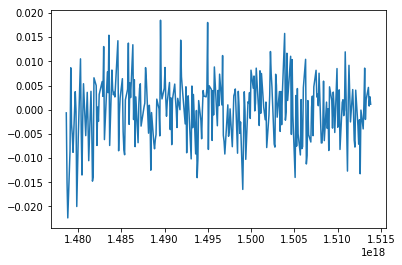

Para realizar a suavisação das ocilações ou tirar um pouco dos resisdos a função `rolling` dos objetos `Series` e `DataFrame` da biblioteca `Pandas` pode ser utilizado jutanemten com a função para calcular a média, `mean`.
```python
df['new_col_name'] = df.col_name.rolling(n).mean()
```
Esta função realiza o calculo levando em consideração o valor de "n" observações anteriores.
Após aplicada desta função a plotagem sobre a nova coluna gerada, que seria a suavisação do grafico aterior, seria parecida com este.
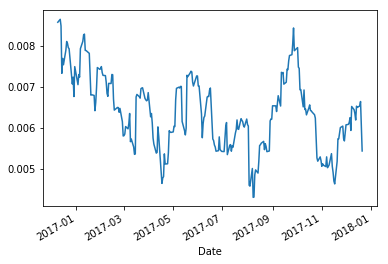

### <a id='4.2'>4.2. Baseline model</a>

Como o próprio nome remete o baseline model é um modelo que é criado para ser usado como base e serve como comparativo para mensurar se os próximos modelos se adequam ou não a base de dados que está sendo trabalhada. Se um modelo alcançar um performance parecida com a do modelo base ou pior, este modelo em questão deve ser ajusatado ou descartado.

Estudiosos afirmam que um bom modelo de base possuem três propriedades:
- **Simples:** Um método que requer pouco ou nenhum treinamento.
- **Rápido:** Um método que pode ser rapidamente implementado e com uma estrutura computacionalmente simples para fazer predições.
- **Replicável:** Um método deterministico, ou seja, produz uma saída experada quando dada a mesma entrada.

Para mensurar a performance dos modelos, tendo em vista que são regressivos e não classificatórios, utilizaremos o R² e a raiza quadrada do erro médio (RMSE).

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

#### <a id='4.2.1'> 4.2.1. Persistence Algorithm" (The "naive" forecast)</a>

Um algoritmo comumente usado como base de performance é o "Persistence Algorithm" (The "naive" forecast), o qual utiliza o valor do passo anterior (t-1) para predizer o valor do passo posterior (t+1), o qual é completamente de acordo com as propriedades para um baseline model, mencionadas anteriormente.

In [ ]:
df_covid19_brazil_infecteds = pd.concat([df_covid19_brazil_infecteds['Infected'],
                                         df_covid19_brazil_infecteds['Infected'].shift(1)], axis=1, keys=['Infected', 'Infected_shifted'])

In [ ]:
df_covid19_brazil_infecteds2 = df_covid19_brazil_infecteds.dropna()

df_covid19_brazil_infecteds2.Mse_baseline = np.sqrt(mean_squared_error(df_covid19_brazil_infecteds2.Infected, df_covid19_brazil_infecteds2.Infected_shifted))
df_covid19_brazil_infecteds2.r2_baseline = r2_score(df_covid19_brazil_infecteds2.Infected, df_covid19_brazil_infecteds2.Infected_shifted)

print('R quadrado: {:.2f}'.format(df_covid19_brazil_infecteds2.r2_baseline))
print('Raiz quadrada do erro médio ao quadrado: {:.2f}'.format(df_covid19_brazil_infecteds2.Mse_baseline))

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Infected / Infected_shifted')
plt.grid()
plt.plot(df_covid19_brazil_infecteds2.Infected, color='Blue', linewidth=2)
plt.plot(df_covid19_brazil_infecteds2.Infected_shifted, color='Red', linewidth=3, linestyle='--')
plt.legend(['Real', 'Predito'])
plt.show()

#### <a id='4.2.2'> 4.2.2. Regressão Linear </a>

```python
from sklearn.linear_model import LinearRegression
```

In [ ]:
from sklearn.linear_model import LinearRegression

Ao tentar utilizar um modelo de regressão linear, descarta-se o fato que uma série tempora sofre flutuaçoes e pressupões que a mesma sempre segue uma tendência linear,o que não é o que acontece, por isto este um model não se adequa para a modelagem deste timpo de dado.

In [ ]:
from sklearn.model_selection import train_test_split
X = np.reshape([i for i in range(0, len(df_covid19_brazil_infecteds2['Infected']))],(-1, 1))
y = df_covid19_brazil_infecteds2['Infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print('R quadrado: {:.2f}'.format(r2_score(y_test, lr_pred)))
print('Raiz quadrada do erro médio ao quadrado: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, lr_pred))))


In [ ]:
'''
Mesmo tendo um R quadrado alto, ainda assim posui um RMSE muito alto,
maior que o base line model por este motivo este não é o melhor modelo 
para se trabalhar com predições de séries temporais.
'''

plt.figure(figsize=(10,10))

plt.title('Predição de séries temporais utilizando Regressão linear')
plt.grid()
plt.plot(X, y, linewidth=2)
plt.plot(X, lr.predict(X), linestyle='--', linewidth=3, color='red')
plt.xlabel('Dias após o primeiro caso')
plt.ylabel('Infectados')
plt.legend(['Real','Predito'])
plt.show()

Como pode-se notar acima, mesmo tendo um R quadrado acima relativamente alto a raiz quadrada do erro médio é bastante alto sendo maior que o do modelo de base, considerando os valores referentes a data da analise.

Contudo, mesmo com seus pontos negativos o modelo de regressão linear simples pode ser utilizado como baseline tendo em vista que é simples rápido e de fácil aplicação, computacionalmente falando.

### <a id='4.3'>4.3. ARIMA - Autoregressive (p) Integrated (d) Moving Averange (q)</a>


#### <a id='4.3.1'>4.3.1 Conceito</a>

O modelo ARIMA, modelo auto-regressivo integrado de médias móveis (autoregressive integrated moving average ou ARIMA, na sigla em inglês) é uma generalização do modelo auto-regressivo de médias móveis (ARMA) que  é utilizado para modelar séries temporais. Modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, em que um passo inicial  de diferenciação (correspondente à parte "Integrado" do AR-I-MA) pode ser aplicado uma ou mais vezes para eliminar a não estacionariedade.

A parte auto-regressiva (AR) do modelo ARIMA indica que a variável evoluinte de interesse é regressada em seus próprios valores defasados, isto é, anteriores. A parte de média móvel (MA) indica que o erro de regressão é na verdade uma combinação linear dos termos de erro, cujos valores ocorreram contemporaneamente e em vários momentos no passado. A parte integrada (I) indica que os valores de dados foram substituídos com a diferença entre seus valores e os valores anteriores e este processo diferenciador pode ter sido realizado mais de uma vez. O propósito da cada uma destas características é fazer o modelo se ajustar aos dados da melhor forma possível.

#### <a id='4.3.2'>4.3.2. Aplicando ARIMA na base de dados</a>

Antes de aplicarmos o modelo aos dados, realizamos algumas análises gáficas para identificar o parâmetro "p" e o parâmetro "q", o parâmetro "d" é referênte à estacionariedade da série a qual pelo gráfico anterior podemos claramente perceber uma tendência que indica a não estacionariedade da série, sendo assim para o parâmetro d aplicamos "1" para um melhor resultado.

Fora utilizado a biblioteca statsmodels para a realização desta análise, mais especificamente a função `plot_acf` e `plot_pacf`  do módulo `graphics.tsaplots`
```python 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
```
Sendo o primeiro `plot_acf` para identificar o valor do parâmetro "q" e o segundo `plot_pacf` utilizado para identificar o valor do parâmetro "p". 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf 

#### <a id='4.3.3'>4.3.3. Autocorrlação (q)</a>

Autocorrelação remete à dependência temporal dos valores sucessivos dos resíduos. É considerado um dos problemas mais sérios em Econometria, pois em muitos modelos econométricos como o ARIMA, o erro aleatório em si são variáveis autocorrelacionadas.
Por isto, no gráfico a seguir, buscamos identificar as correlações e os padrões formados ao longo da série para ajustarmos o melhor modelo atribuindo e modificando a parte MA do modelo ARIMA, ou seja o parâmetro q.
Na parte esquerda do gráfico temos uma escala representado o coeficiente de correlação de Pearson e na parte inferior o valor de cada elemento o qual deverá ser atribuída ao parâmetro "q", a área representada em azul claro no gráfico é a área crítica.


In [ ]:
# identificar o parâmetro q
plot_acf(df_covid19_brazil_infecteds2.Infected)
plt.show()

#### <a id='4.3.4'> 4.3.4. Autocorrelação Parcial (p)</a>

A autocorrelação parcial é realizada também para verificar as correlação, contudo, esta reduz o efeito de correlação entre grupos pequenos de elemetos. 
Assim como no gráfico anterior buscamos padrões e correlações, neste caso, que nos leve a utilizar a parte AR do ARIMA ou seja o parâmetro p.

In [ ]:
# identificar o parâmetro p
plot_pacf(df_covid19_brazil_infecteds2.Infected)
plt.show()

#### <a id='4.3.5'> 4.3.5. Predição com ARIMA</a>

In [ ]:
train_size = int(len(df_covid19_brazil_infecteds2) * 0.70)
df_covid19_brazil_infecteds2_train = df_covid19_brazil_infecteds2.Infected[:train_size].values.reshape(-1,1)
df_covid19_brazil_infecteds2_test = df_covid19_brazil_infecteds2.Infected[train_size:].values.reshape(-1,1)
print('Treino: {} observações.'.format(df_covid19_brazil_infecteds2_train.shape[0]))
print('Teste: {} observações.'.format(df_covid19_brazil_infecteds2_test.shape[0]))

Aplicaremos o modelo ARIMA utilizando a função `ARIMA` da biblioteca `statsmodels.tsa.arima_model`.
```python
from statsmodels.tsa.arima_model import ARIMA
```

Foram realizadas diversas combinações no intúito de compara os resultados.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
df_teste_arima = pd.DataFrame([])
rmse = pd.Series([])
ordem = pd.Series([])
r2 = pd.Series([])
aic = pd.Series([])
predicoes = pd.DataFrame([])
c = 0

for i in range(0, 6):
    for j in range(0, 2):
        for k in range(0, 6):
            try:
                # instacia o modelo
                df_covid19_brazil_infecteds_model = ARIMA(df_covid19_brazil_infecteds2_train, order=(i,j,k))
                # Ajusta o modelo
                df_covid19_brazil_infecteds_model_fit = df_covid19_brazil_infecteds_model.fit()
                # Calcula o AIC
                aic[c] = df_covid19_brazil_infecteds_model_fit.aic
                # realiza a predição
                df_covid19_brazil_infecteds_model_fit_forecast = df_covid19_brazil_infecteds_model_fit.forecast(steps=(len(df_covid19_brazil_infecteds2)-train_size))[0]
                # salva a ordem que está sendo utilizada no ARIMA
                ordem[c] = '({}, {}, {})'.format(i,j,k)
                # Salva o r2
                r2[c] = r2_score(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_fit_forecast)
                # salva o RMSE
                rmse[c] = np.sqrt(mean_squared_error(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_fit_forecast))

                # Salva as prediçoes deste ARIMA
                predicoes.insert(c, ordem[c] , df_covid19_brazil_infecteds_model_fit_forecast)

                c += 1
            except:
                continue


df_teste_arima = pd.concat([ordem, r2, rmse, aic], axis=1, keys=['Order', 'R2_score', 'RSME', 'AIC']).sort_values(by=['R2_score','RSME', 'AIC'], ascending=False)

Asseguir temos os resultados de cada um dos testes.

In [ ]:
df_teste_arima

Devido à quantidade de observações não foi possível obter resultados satisfatórios aplicando arima nesta base de dados. Este modelo teve performance menor que o base line. 

In [ ]:
plt.figure(figsize=(20,15))
if len(df_teste_arima) % 2 == 0:
    for c in range(len(df_teste_arima)):
        plt.subplot(int(len(df_teste_arima)/4),4,c+1)
        plt.title('Arima Ordem: {}'.format(predicoes.columns[c]))
        plt.grid()
        plt.plot(df_covid19_brazil_infecteds2_train, linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in df_covid19_brazil_infecteds2_test], linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in predicoes[predicoes.columns[c]]], linestyle='--', color='red', linewidth=3)
        plt.legend(['Treino', 'Teste', 'Predito'])
else: 
    for c in range(len(df_teste_arima)):
        plt.subplot(np.ceil(int(len(df_teste_arima)/3))+1,3,c+1)
        plt.title('Arima Ordem: {}'.format(predicoes.columns[c]))
        plt.grid()
        plt.plot(df_covid19_brazil_infecteds2_train, linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in df_covid19_brazil_infecteds2_test], linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in predicoes[predicoes.columns[c]]], linestyle='--', color='red', linewidth=3)
        plt.legend(['Treino', 'Teste', 'Predito'])
plt.tight_layout() 
plt.show()

Este modelo obteve menos performance que o modelo de base, sendo assim, por hora ele não seria adequado. Contudo, creio que isto esteja diretamente relacionado à quantidade de dados no momento da análise.

### <a id='4.4.'>4.4. Holt-Winters</a>

#### <a id='4.4.1'>4.4.1. Conceito</a>

A suavização exponencial tripla , também conhecida como método de Holt-Winters, é um dos muitos métodos ou algoritmos que podem ser usados para prever pontos de dados em uma série, desde que a série seja “sazonal”, ou seja, repetitiva durante algum período.

#### <a id='4.4.2'>4.4.2. Predizendo com Holt-Winters'</a>

Para realizar a modelagem utilizando a técnica Holt-Winters foi utilizada a função `ExponentialSmoothing` da biblioteca `statsmodels.tsa.holtwinters`

```python
from statsmodels.tsa.holtwinters import ExponentialSmoothing
```

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Instaciando o modelo sem modificar os parâmetros

In [ ]:
df_covid19_brazil_infecteds_model_hw_fit = ExponentialSmoothing(df_covid19_brazil_infecteds2_train).fit()
df_covid19_brazil_infecteds_model_hw_predict = df_covid19_brazil_infecteds_model_hw_fit.predict(start = train_size + 1, end = len(df_covid19_brazil_infecteds2.Infected))
print('Raiz quadrada do erro médio: {}'.format(np.sqrt(mean_squared_error(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_fit_forecast))))
print('AIC: {}'.format(df_covid19_brazil_infecteds_model_hw_fit.aic))
print('R quadrado: {}'.format(r2_score(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_hw_predict)))

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Modelo Holt-Winters sem ajuste dos parâmetros')
plt.grid()
plt.plot(df_covid19_brazil_infecteds2_train)
plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [x for x in df_covid19_brazil_infecteds2_test])
plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [x for x in df_covid19_brazil_infecteds_model_hw_predict])
plt.show()

Sem modificar o parâmetro o modelo infelizmente não conseguiu predizer com precisão, analisando os parâmetros de comparação emitidos podemos ver que o R quadrado saiu negativo e um RMSE muito ruim o que indica um subajuste do modelo que podemos atribuir à quantidade de dados na data da análise.


Instaciando o modelo modificando os parâmetros de sazonalidade e tendência.

Seguem os resultados das combinações:

In [ ]:
predicoes_holtWinter = pd.DataFrame()
params = pd.Series([])
aic = pd.Series([])
r2 = pd.Series([])
rmse = pd.Series([])
c = 0 
for trend in ('add', 'mul'):
    for seasonal in ('add', 'mul'):
        params[c] = 'Trend: {} + Seasonal: {}'.format(trend, seasonal) 
        df_covid19_brazil_infecteds_model_hw_fit = ExponentialSmoothing(df_covid19_brazil_infecteds2_train, trend, seasonal).fit()
        df_covid19_brazil_infecteds_model_hw_predict = df_covid19_brazil_infecteds_model_hw_fit.predict(start = train_size + 1, end = len(df_covid19_brazil_infecteds2.Infected))
        aic[c] = df_covid19_brazil_infecteds_model_hw_fit.aic
        r2[c] = r2_score(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_hw_predict)
        # salva o RMSE
        
        rmse[c] = np.sqrt(mean_squared_error(df_covid19_brazil_infecteds2_test, df_covid19_brazil_infecteds_model_fit_forecast))
        predicoes_holtWinter.insert(c, params[c], df_covid19_brazil_infecteds_model_hw_predict)
        c +=1

df_teste_holtwinter = pd.concat([params, r2, rmse, aic], axis=1, keys=['Parametros', 'R2_score', 'RSME', 'AIC']).sort_values(by=['R2_score','RSME', 'AIC'], ascending=False)        

In [ ]:
df_teste_holtwinter

In [ ]:
plt.figure(figsize=(20,15))
if len(df_teste_holtwinter) % 2 == 0:
    for c in range(len(df_teste_holtwinter)):
        plt.subplot(int(len(df_teste_holtwinter)/2),2,c+1)
        plt.title('Parâmetros: {}'.format(predicoes_holtWinter.columns[c]))
        plt.grid()
        plt.plot(df_covid19_brazil_infecteds2_train, linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in df_covid19_brazil_infecteds2_test], linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in predicoes_holtWinter[predicoes_holtWinter.columns[c]]], linestyle='--', color='red', linewidth=3)
        plt.legend(['Treino', 'Teste', 'Predito'])
else: 
    for c in range(len(df_teste_holtwinter)):
        plt.subplot(np.ceil(int(len(df_teste_holtwinter)/3))+1,3,c+1)
        plt.title('Parâmetros {}'.format(predicoes_holtWinter.columns[c]))
        plt.grid()
        plt.plot(df_covid19_brazil_infecteds2_train, linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in df_covid19_brazil_infecteds2_test], linewidth=2)
        plt.plot([None for i in df_covid19_brazil_infecteds2_train] + [j for j in predicoes_holtWinter[predicoes_holtWinter.columns[c]]], linestyle='--', color='red', linewidth=3)
        plt.legend(['Treino', 'Teste', 'Predito'])
plt.tight_layout() 
plt.show()

Este modelo também obteve performance insuficiente, ou seja, a baixo do baseline model, tendo em vista o R quadrado negativo e RMSE podemos atribuir também esta performance pobre à quantidade de dados disponíveis para treino.

---

## <a id='5'>5. Conclusão</a>

Com este trabalho pude perceber a importância de um base line para a avaliação dos modelos e pude concluir que até mesmo os modelos mais sofisticados de predição podem ser prejudicados na hora da predição, caso não haja a quantidade ncessária para treinamento. Além disso pude perceber também o quão efetivo é esta abordagem hands on para a aprendizagem na área de programação e análise de dados.

---

## <a id='6'> 6. Fontes </a>

https://pt.wikipedia.org/wiki/S%C3%A9rie_temporal
https://pt.wikipedia.org/wiki/ARIMA#cite_note-2 <br/>
http://www.portalaction.com.br/series-temporais/11-estacionariedade <br/>
https://nbviewer.jupyter.org/urls/alphabench.com/data/pandas_rolling_method.ipynb <br/>
https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/ <br/>
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/ <br/>
https://siteantigo.portaleducacao.com.br/conteudo/artigos/contabilidade/autocorrelacao/52161
https://support.minitab.com/pt-br/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/